# **Part1**

In [25]:
!pip install mtcnn

In [26]:
!pip install keras_facenet

In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mtcnn import MTCNN
from keras_facenet import FaceNet
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from collections import Counter

In [28]:
# Define paths
DATA_DIR = "/content/drive/MyDrive/face_recognition/dataset"

In [29]:
# Function to load images from directory
def load_images_from_dir(dir_path, label):
    images = []
    labels = []
    for filename in os.listdir(dir_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(dir_path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            images.append(img)
            labels.append(label)
    return images, labels

In [30]:
# Function to load all images
def load_all_images(data_dir):
    persons_dirs = ["Brian_Acton", "bill_gates", "elon_musk","mark_zuckerberg"]
    images = []
    labels = []

    for person in persons_dirs:
        dir_path = os.path.join(data_dir, person)
        imgs, lbls = load_images_from_dir(dir_path, person)
        images.extend(imgs)
        labels.extend(lbls)

    return np.array(images), np.array(labels)


In [31]:
# Initialize FaceNet
embedder = FaceNet()

# Function to get embeddings
def get_embedding(face_img, embedder):
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)
    yhat = embedder.embeddings(face_img)
    return yhat[0]


In [32]:
import os
import cv2

def load_images_from_dir(dir_path, label):
    images = []
    labels = []
    for filename in os.listdir(dir_path):
        img_path = os.path.join(dir_path, filename)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        images.append(img)
        labels.append(label)
    return images, labels

def load_all_images(data_dir):
    X, Y = [], []
    for label_dir in os.listdir(data_dir):
        dir_path = os.path.join(data_dir, label_dir)
        if not os.path.isdir(dir_path):
            continue
        images, labels = load_images_from_dir(dir_path, label_dir)
        X.extend(images)
        Y.extend(labels)
    return X, Y

# Load all images
DATA_DIR = '/content/drive/MyDrive/face_recognition/dataset'
X, Y = load_all_images(DATA_DIR)

# Calculate embeddings
EMBEDDED_X = [get_embedding(img, embedder) for img in X]
# Save embeddings and labels
np.save('EMBEDDED_X.npy', EMBEDDED_X)
np.save('Y.npy', Y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [33]:
# Encode labels
encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(Y)

# Assuming EMBEDDED_X is a list of embeddings
EMBEDDED_X = np.array(EMBEDDED_X)

# Flatten data
EMBEDDED_X_flat = EMBEDDED_X.reshape(EMBEDDED_X.shape[0], -1)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(EMBEDDED_X_flat, Y_encoded, test_size=0.2, random_state=42)


In [34]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np

# Définition de l'espace de recherche
space = {
    'C': hp.loguniform('C', np.log(0.001), np.log(1000)),
    'gamma': hp.loguniform('gamma', np.log(0.0001), np.log(1)),
}

# Fonction objectif
def objective(params):
    svc = SVC(kernel='rbf', probability=True, **params)
    accuracy = cross_val_score(svc, X_train, y_train, cv=3, scoring='accuracy').mean()
    return {'loss': -accuracy, 'status': STATUS_OK}

# Optimisation
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Best parameters found: ", best_params)


100%|██████████| 100/100 [00:03<00:00, 29.57trial/s, best loss: -0.7402597402597403]
Best parameters found:  {'C': 223.1725738751212, 'gamma': 0.9581735311903928}


In [35]:
!pip install tensorflow


# **Part2**

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [37]:
# Importer les bibliothèques nécessaires
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mtcnn import MTCNN
from keras_facenet import FaceNet
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [38]:
HAARCASCADE_PATH = "/content/drive/MyDrive/face_recognition/haarcascade_frontalface_default.xml"
SIMILARITY_THRESHOLD = 0.6

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


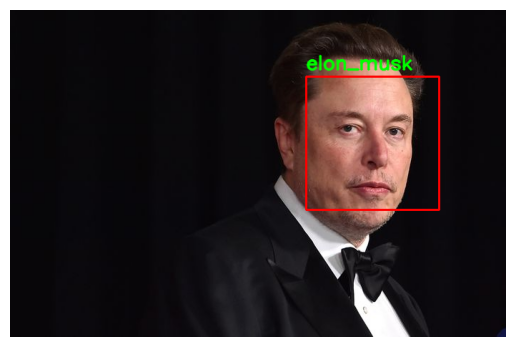

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


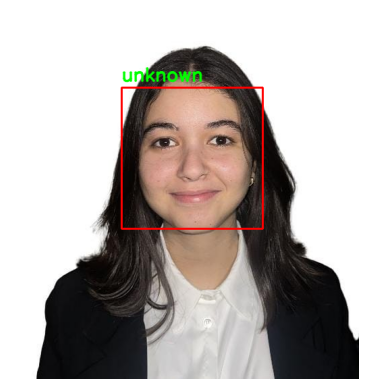

In [39]:
# Initialize FaceNet and Haarcascade
facenet = FaceNet()
haarcascade = cv2.CascadeClassifier(HAARCASCADE_PATH)

# Load the known embeddings and labels (assumes they are saved previously)
EMBEDDED_X = np.load('EMBEDDED_X.npy')
Y = np.load('Y.npy')

# Function to get embeddings
def get_embedding(face_img, embedder):
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)
    yhat = embedder.embeddings(face_img)
    return yhat[0]

# Function to recognize faces in an image
def recognize_faces(image_path):
    image = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = haarcascade.detectMultiScale(gray_img, 1.3, 5)

    for (x, y, w, h) in faces:
        face = rgb_img[y:y + h, x:x + w]
        face = cv2.resize(face, (160, 160))
        embedding = get_embedding(face, facenet)

        # Calculate similarity with known embeddings
        similarities = cosine_similarity([embedding], EMBEDDED_X)
        max_similarity = np.max(similarities)

        # Determine the label based on similarity
        if max_similarity < SIMILARITY_THRESHOLD:
            final_name = 'unknown'
        else:
            best_match_index = np.argmax(similarities)
            final_name = Y[best_match_index]

        # Draw rectangle and label on the image
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(image, str(final_name), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Test the function
image_path1 = "/content/drive/MyDrive/face_recognition/IMG-20240227-WA0014.jpg"
image_path2 = "/content/drive/MyDrive/face_recognition/téléchargement.jpeg"
recognize_faces(image_path2)
recognize_faces(image_path1)
